In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.calibration import CalibratedClassifierCV
from collections import Counter
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

In [3]:
df=pd.read_csv('/content/drive/MyDrive/preprocessed_data_fake_real_news.csv')

In [4]:
df.head()

,Unnamed: 0,title,text,subject,date,target,original
0,0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0,donald trump just couldn t wish all americans ...
1,1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0,house intelligence committee chairman devin nu...
2,2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0,on friday it was revealed that former milwauke...
3,3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0,on christmas day donald trump announced that h...
4,4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0,pope francis used his annual christmas day mes...


In [ ]:
X = df.drop(['Unnamed: 0','title','text','subject','date','target'], axis=1)
Y = df['target'].values

In [ ]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.33,stratify=Y)
X_train,X_cv,Y_train,Y_cv=train_test_split(X_train,Y_train,test_size=0.33,stratify=Y_train)
print("X_train shape:",X_train.shape)
print("X_test shape:",X_test.shape)
print("Y_train shape:",Y_train.shape)
print("Y_test shape:",Y_test.shape)
print("X_cv shape:",X_cv.shape)
print("Y_cv shape:",Y_cv.shape)

X_train shape: (20154, 1)
X_test shape: (14817, 1)
Y_train shape: (20154,)
Y_test shape: (14817,)
X_cv shape: (9927, 1)
Y_cv shape: (9927,)


#### a.Applying BOW(Bag Of Words)

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['original'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer.transform(X_train['original'].values)
X_cv_essay_bow = vectorizer.transform(X_cv['original'].values)
X_test_essay_bow = vectorizer.transform(X_test['original'].values)

print("After vectorizations")
print("="*100)
print("shape of the matrix of X_train_eassy",X_train_essay_bow.shape, Y_train.shape)
print("shape of the matrix of X_cv_eassy",X_cv_essay_bow.shape, Y_cv.shape)
print("shape of the matrix of X_test_eassy",X_test_essay_bow.shape, Y_test.shape)
print("="*100)

After vectorizations
shape of the matrix of X_train_eassy (20154, 87163) (20154,)
shape of the matrix of X_cv_eassy (9927, 87163) (9927,)
shape of the matrix of X_test_eassy (14817, 87163) (14817,)


## Applying Machine Learning Models

#### a.KNN Classifier

In [ ]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [0,1]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(6,4))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(6,4))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(6,4))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [ ]:
#Data preparation for ML models.

#Misc. functionns for ML models


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [ ]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

for alpha = 5
Log Loss : 0.3528209532591348
for alpha = 11
Log Loss : 0.3720808396171922
for alpha = 15
Log Loss : 0.3810486547903741
for alpha = 21
Log Loss : 0.3913849862935935
for alpha = 31
Log Loss : 0.40489001523006696
for alpha = 41
Log Loss : 0.415914689622446
for alpha = 51
Log Loss : 0.4258118394134389
for alpha = 99
Log Loss : 0.4567759751232976


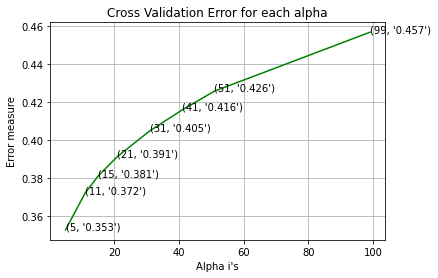

For values of best alpha =  5 The train log loss is: 0.26917863578536655
For values of best alpha =  5 The cross validation log loss is: 0.3528209532591348
For values of best alpha =  5 The test log loss is: 0.3612242710079023


In [ ]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(X_train_essay_bow,Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_essay_bow,Y_train)
    
    sig_clf_probs = sig_clf.predict_proba(X_cv_essay_bow)
    cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(X_train_essay_bow,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow,Y_train)

predict_y = sig_clf.predict_proba(X_train_essay_bow)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv_essay_bow)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_essay_bow)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log loss : 0.3528209532591348
Number of mis-classified points : 0.13901480809912362
-------------------- Confusion matrix --------------------


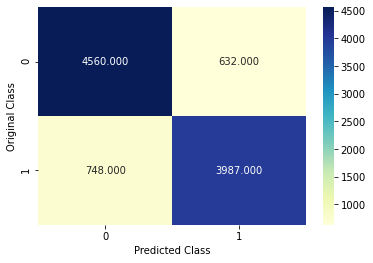

-------------------- Precision matrix (Columm Sum=1) --------------------


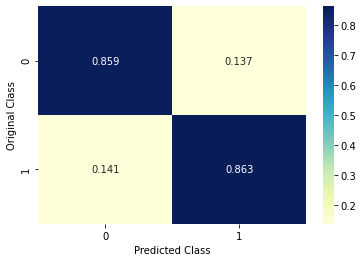

-------------------- Recall matrix (Row sum=1) --------------------


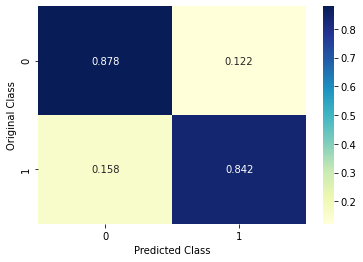

In [ ]:
# find more about KNeighborsClassifier() here http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# -------------------------
# default parameter
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
# metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)

# methods of
# fit(X, y) : Fit the model using X as training data and y as target values
# predict(X):Predict the class labels for the provided data
# predict_proba(X):Return probability estimates for the test data X.
#-------------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/k-nearest-neighbors-geometric-intuition-with-a-toy-example-1/
#-------------------------------------
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(X_train_essay_bow,Y_train,X_cv_essay_bow, Y_cv, clf)

#### testing one query point1

In [ ]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(X_train_essay_bow,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow,Y_train)

test_point_index = 10

predicted_cls = sig_clf.predict(X_test_essay_bow[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", Y_test[test_point_index])
neighbors = clf.kneighbors(X_test_essay_bow[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",
      Y_train[neighbors[1][0]])
print("Fequency of nearest points :",Counter(Y_train[neighbors[1][0]]))

Predicted Class : 1
Actual Class : 1
the k value for knn is 5 and the nearest neighbours of the test points belongs to classes [1 1 1 1 1]
Fequency of nearest points : Counter({1: 5})


#### testing one query point2

In [ ]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(X_train_essay_bow,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow,Y_train)

test_point_index = -1

predicted_cls = sig_clf.predict(X_test_essay_bow[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", Y_test[test_point_index])
neighbors = clf.kneighbors(X_test_essay_bow[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",
      Y_train[neighbors[1][0]])
print("Fequency of nearest points :",Counter(Y_train[neighbors[1][0]]))

Predicted Class : 0
Actual Class : 0
the k value for knn is 5 and the nearest neighbours of the test points belongs to classes [0 0 0 0 0]
Fequency of nearest points : Counter({0: 5})


#### b.Naive bayes

for alpha = 1e-05
Log Loss : 0.15337634422092966
for alpha = 0.0001
Log Loss : 0.15447349638646868
for alpha = 0.001
Log Loss : 0.1561362851798946
for alpha = 0.1
Log Loss : 0.1678562934321899
for alpha = 1
Log Loss : 0.17770222321503817
for alpha = 10
Log Loss : 0.18821898104304619
for alpha = 100
Log Loss : 0.2846055677620939
for alpha = 1000
Log Loss : 0.4844279824692316


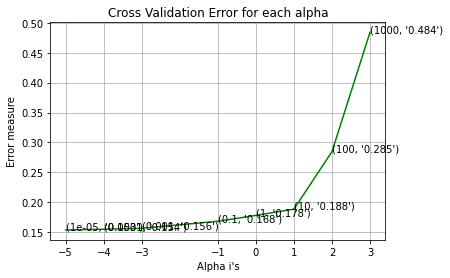

For values of best alpha =  1e-05 The train log loss is: 0.09072522607806416
For values of best alpha =  1e-05 The cross validation log loss is: 0.15337634422092966
For values of best alpha =  1e-05 The test log loss is: 0.16072743043393356


In [ ]:
# find more about Multinomial Naive base function here http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
# -------------------------
# default paramters
# sklearn.naive_bayes.MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

# some of methods of MultinomialNB()
# fit(X, y[, sample_weight])	Fit Naive Bayes classifier according to X, y
# predict(X)	Perform classification on an array of test vectors X.
# predict_log_proba(X)	Return log-probability estimates for the test vector X.
# -----------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/naive-bayes-algorithm-1/
# -----------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
# ----------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/naive-bayes-algorithm-1/
# -----------------------


alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(X_train_essay_bow,Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_essay_bow,Y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cv_essay_bow)
    cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(X_train_essay_bow,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow,Y_train)


predict_y = sig_clf.predict_proba(X_train_essay_bow)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv_essay_bow)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_essay_bow)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log loss : 0.15337634422092966
Number of mis-classified points : 0.04029414727510829
-------------------- Confusion matrix --------------------


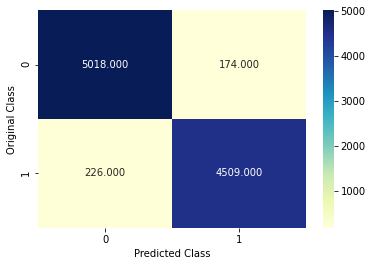

-------------------- Precision matrix (Columm Sum=1) --------------------


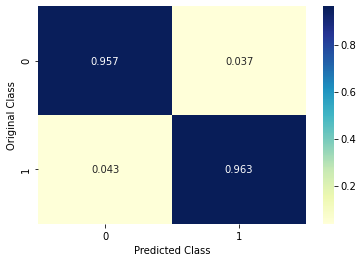

-------------------- Recall matrix (Row sum=1) --------------------


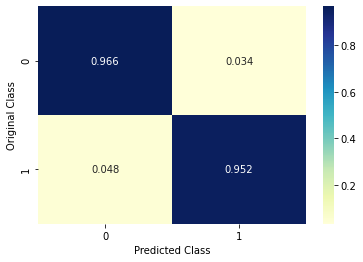

In [ ]:
# find more about KNeighborsClassifier() here http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# -------------------------
# default parameter
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
# metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)

# methods of
# fit(X, y) : Fit the model using X as training data and y as target values
# predict(X):Predict the class labels for the provided data
# predict_proba(X):Return probability estimates for the test data X.
#-------------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/k-nearest-neighbors-geometric-intuition-with-a-toy-example-1/
#-------------------------------------
clf = MultinomialNB(alpha=alpha[best_alpha])
predict_and_plot_confusion_matrix(X_train_essay_bow,Y_train,X_cv_essay_bow, Y_cv, clf)

#### Query point1

In [ ]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(X_train_essay_bow,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow,Y_train)

test_point_index = 100

predicted_cls = sig_clf.predict(X_test_essay_bow[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", Y_test[test_point_index])

Predicted Class : 1
Actual Class : 1


#### Query point2

In [ ]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(X_train_essay_bow,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow,Y_train)

test_point_index = 20

predicted_cls = sig_clf.predict(X_test_essay_bow[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", Y_test[test_point_index])

Predicted Class : 0
Actual Class : 1


#### c.LogisticRegression

for alpha = 1e-06
Log Loss : 0.04270587810307537
for alpha = 1e-05
Log Loss : 0.041772227739337704
for alpha = 0.0001
Log Loss : 0.04220751594688325
for alpha = 0.001
Log Loss : 0.04180829580063045
for alpha = 0.01
Log Loss : 0.04998756740151969
for alpha = 0.1
Log Loss : 0.08916488945311585
for alpha = 1
Log Loss : 0.15140054782280912


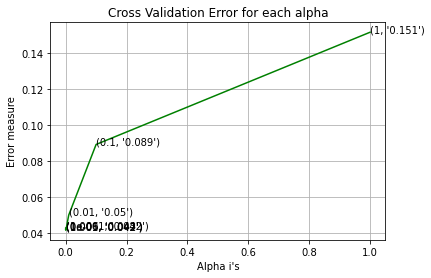

For values of best alpha =  1e-05 The train log loss is: 0.0203115204621974
For values of best alpha =  1e-05 The cross validation log loss is: 0.041772227739337704
For values of best alpha =  1e-05 The test log loss is: 0.03760632873227821


In [ ]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------



# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train_essay_bow,Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_essay_bow,Y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cv_essay_bow)
    cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train_essay_bow,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow,Y_train)

predict_y = sig_clf.predict_proba(X_train_essay_bow)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv_essay_bow)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_essay_bow)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 0.041772227739337704
Number of mis-classified points : 0.007958094086833888
-------------------- Confusion matrix --------------------


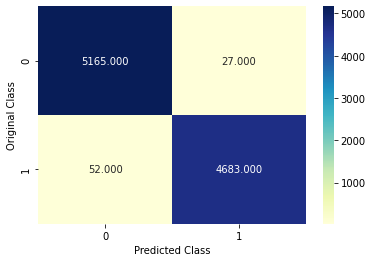

-------------------- Precision matrix (Columm Sum=1) --------------------


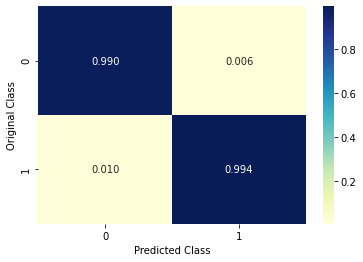

-------------------- Recall matrix (Row sum=1) --------------------


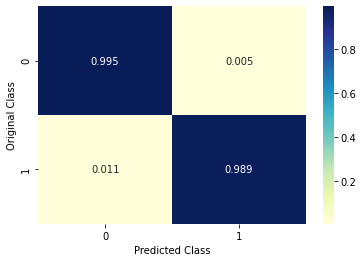

In [ ]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(X_train_essay_bow, Y_train,X_cv_essay_bow, Y_cv, clf)

#### Query point1

In [ ]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train_essay_bow,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow,Y_train)

test_point_index = 100

predicted_cls = sig_clf.predict(X_test_essay_bow[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", Y_test[test_point_index])

Predicted Class : 1
Actual Class : 1


#### Querypoint2

In [ ]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train_essay_bow,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow,Y_train)

test_point_index = 20

predicted_cls = sig_clf.predict(X_test_essay_bow[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", Y_test[test_point_index])

Predicted Class : 0
Actual Class : 1


#### d.SVC

for C = 1e-05
Log Loss : 0.04511956611542015
for C = 0.0001
Log Loss : 0.04193907851800336
for C = 0.001
Log Loss : 0.038827228712513574
for C = 0.01
Log Loss : 0.03613485904404792
for C = 0.1
Log Loss : 0.04820240218214947
for C = 1
Log Loss : 0.10886909282116128
for C = 10
Log Loss : 0.1836032690314159
for C = 100
Log Loss : 0.4284113133672647


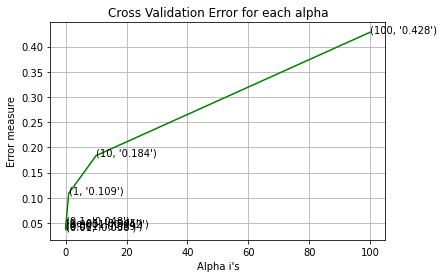

For values of best alpha =  0.01 The train log loss is: 0.01593993827866597
For values of best alpha =  0.01 The cross validation log loss is: 0.03613485904404792
For values of best alpha =  0.01 The test log loss is: 0.03215042826877151


In [ ]:
# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# --------------------------------
# default parameters 
# SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, 
# cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)

# Some of methods of SVM()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/mathematical-derivation-copy-8/
# --------------------------------



# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(X_train_essay_bow,Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_essay_bow,Y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cv_essay_bow)
    cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(X_train_essay_bow,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow,Y_train)

predict_y = sig_clf.predict_proba(X_train_essay_bow)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv_essay_bow)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_essay_bow)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 0.03659388522404664
Number of mis-classified points : 0.0075551526140828044
-------------------- Confusion matrix --------------------


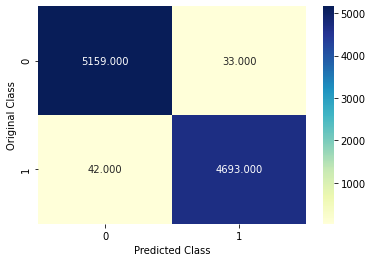

-------------------- Precision matrix (Columm Sum=1) --------------------


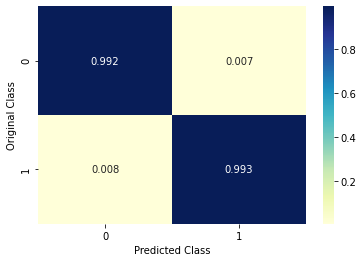

-------------------- Recall matrix (Row sum=1) --------------------


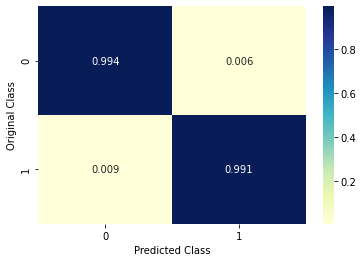

In [ ]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(X_train_essay_bow, Y_train,X_cv_essay_bow, Y_cv, clf)

#### Query point1

In [ ]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(X_train_essay_bow,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow,Y_train)

test_point_index = 500

predicted_cls = sig_clf.predict(X_test_essay_bow[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", Y_test[test_point_index])

Predicted Class : 1
Actual Class : 1


#### query point2

In [ ]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(X_train_essay_bow,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow,Y_train)

test_point_index = 456

predicted_cls = sig_clf.predict(X_test_essay_bow[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", Y_test[test_point_index])

Predicted Class : 1
Actual Class : 1


##### e. Random Forest Classifier

for n_estimators = 100 and max depth =  5
Log Loss : 0.10915880195329149
for n_estimators = 100 and max depth =  10
Log Loss : 0.0783961905827449
for n_estimators = 200 and max depth =  5
Log Loss : 0.10710470771533737
for n_estimators = 200 and max depth =  10
Log Loss : 0.07781204156821532
for n_estimators = 500 and max depth =  5
Log Loss : 0.11090642692571988
for n_estimators = 500 and max depth =  10
Log Loss : 0.07701237842531107
for n_estimators = 1000 and max depth =  5
Log Loss : 0.1061369041307744
for n_estimators = 1000 and max depth =  10
Log Loss : 0.07714705106449807
for n_estimators = 2000 and max depth =  5
Log Loss : 0.10748891842500884
for n_estimators = 2000 and max depth =  10
Log Loss : 0.0773971686392047


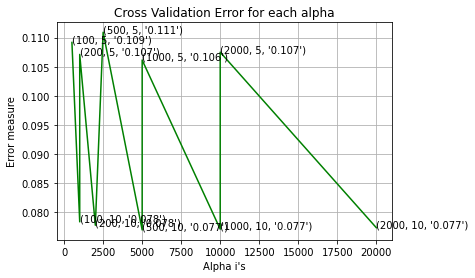

For values of best estimator =  500 The train log loss is: 0.04797716222193651
For values of best estimator =  500 The cross validation log loss is: 0.07701237842531106
For values of best estimator =  500 The test log loss is: 0.07512625845605897


In [ ]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(X_train_essay_bow,Y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(X_train_essay_bow,Y_train)
        sig_clf_probs = sig_clf.predict_proba(X_cv_essay_bow)
        cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(X_train_essay_bow,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow,Y_train)

predict_y = sig_clf.predict_proba(X_train_essay_bow)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv_essay_bow)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_essay_bow)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 0.07701237842531107
Number of mis-classified points : 0.026896343306134784
-------------------- Confusion matrix --------------------


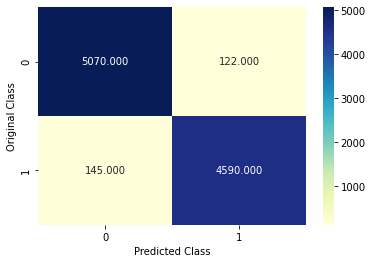

-------------------- Precision matrix (Columm Sum=1) --------------------


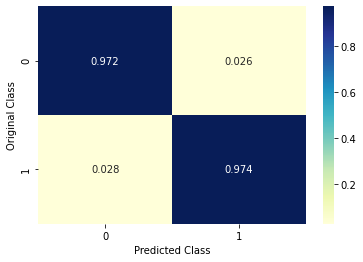

-------------------- Recall matrix (Row sum=1) --------------------


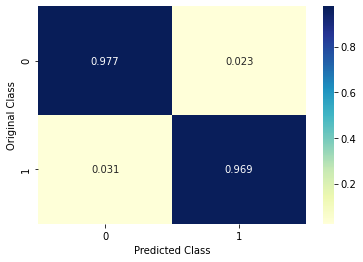

In [ ]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------

clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], 
                             random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(X_train_essay_bow, Y_train,X_cv_essay_bow, Y_cv, clf)

#### Query point1

In [ ]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(X_train_essay_bow,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow,Y_train)

test_point_index = 100

predicted_cls = sig_clf.predict(X_test_essay_bow[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", Y_test[test_point_index])

Predicted Class : 1
Actual Class : 1


#### Querypoint2

In [ ]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(X_train_essay_bow,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow,Y_train)

test_point_index = 20

predicted_cls = sig_clf.predict(X_test_essay_bow[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", Y_test[test_point_index])

Predicted Class : 0
Actual Class : 1


#### f.XGBoost classifier

log_loss for c =  10 is 0.017878413396743002
log_loss for c =  50 is 0.01547255847233533
log_loss for c =  100 is 0.015360985849293634
log_loss for c =  500 is 0.015246240588438834
log_loss for c =  1000 is 0.0152500292695341
log_loss for c =  2000 is 0.015454988220489243


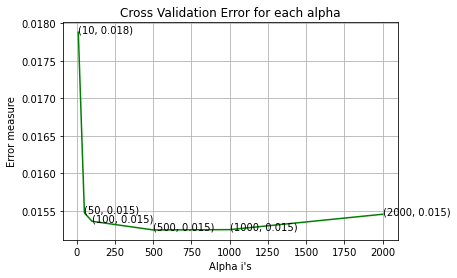

For values of best alpha =  500 The train log loss is: 0.004687667636690827
For values of best alpha =  500 The cross validation log loss is: 0.015246240588438834
For values of best alpha =  500 The test log loss is: 0.013005839333623662


In [ ]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link1: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/regression-using-decision-trees-2/
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

alpha=[10,50,100,500,1000,2000]
cv_log_error_array=[]
for i in alpha:
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1)
    x_cfl.fit(X_train_essay_bow,Y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train_essay_bow,Y_train)
    predict_y = sig_clf.predict_proba(X_cv_essay_bow)
    cv_log_error_array.append(log_loss(Y_cv, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],nthread=-1)
x_cfl.fit(X_train_essay_bow,Y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train_essay_bow,Y_train)
    
predict_y = sig_clf.predict_proba(X_train_essay_bow)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv_essay_bow)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test_essay_bow)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y))

Log loss : 0.015246240588438834
Number of mis-classified points : 0.0027198549410698096
-------------------- Confusion matrix --------------------


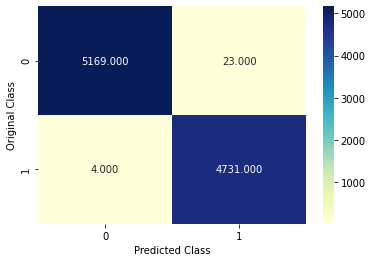

-------------------- Precision matrix (Columm Sum=1) --------------------


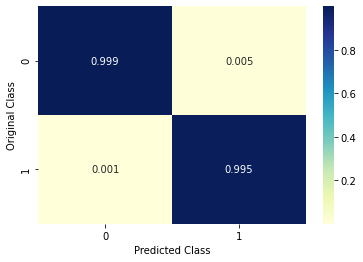

-------------------- Recall matrix (Row sum=1) --------------------


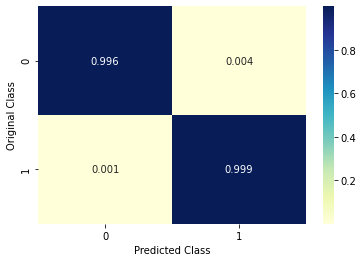

In [ ]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------

clf = XGBClassifier(n_estimators=alpha[best_alpha],random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(X_train_essay_bow, Y_train,X_cv_essay_bow, Y_cv, clf)

#### XgBoost Classification with best hyper parameters using RandomSearch

In [ ]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
x_cfl=XGBClassifier()
prams={'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2]}
random_cfl1=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl1.fit(X_train_essay_bow,Y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  4.6min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  5.1min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  5.9min remaining:   39.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.0min finished


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                           reg_lamb

In [ ]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
x_cfl=XGBClassifier()
prams={'max_depth':[3,5,10]}
random_cfl2=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl2.fit(X_train_essay_bow,Y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:   49.8s remaining:  5.4min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:   50.3s remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:  1.2min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  1.2min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  2.0min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  2.2min remaining:   33.2s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.4min finished


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                           reg_lamb

In [ ]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
x_cfl=XGBClassifier()
prams={'n_estimators':[100,200,500,1000,2000]}
random_cfl3=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl3.fit(X_train_essay_bow,Y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:  5.1min remaining:  4.7min
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:  8.2min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed: 11.1min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed: 15.4min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 16.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 16.8min finished


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                           reg_lamb

In [ ]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
x_cfl=XGBClassifier()
prams={'colsample_bytree':[0.1,0.3,0.5,1]}
random_cfl4=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl4.fit(X_train_essay_bow,Y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:   41.4s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  1.2min remaining:   57.2s
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:  1.4min remaining:   36.7s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:  1.9min remaining:   19.5s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.9min finished


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                           reg_lamb

In [ ]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
x_cfl=XGBClassifier()
prams={'subsample':[0.1,0.3,0.5,1]}
random_cfl5=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl5.fit(X_train_essay_bow,Y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:  1.1min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  1.9min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:  2.2min remaining:   56.4s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:  2.5min remaining:   26.8s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.6min finished


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                           reg_lamb

In [ ]:
print(random_cfl1.best_params_)
print(random_cfl2.best_params_)
print(random_cfl3.best_params_)
print(random_cfl4.best_params_)
print(random_cfl5.best_params_)

{'learning_rate': 0.1}
{'max_depth': 3}
{'n_estimators': 100}
{'colsample_bytree': 0.1}
{'subsample': 0.3}


train loss 0.012819142091524608
cv loss 0.014819478359675044
test loss 0.015231041185501294
Log loss : 0.014819478359675044
Number of mis-classified points : 0.004633826936637453
-------------------- Confusion matrix --------------------


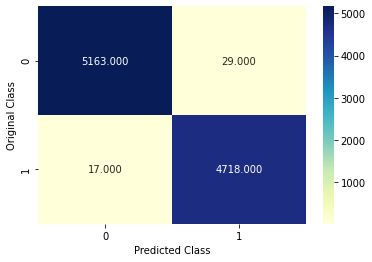

-------------------- Precision matrix (Columm Sum=1) --------------------


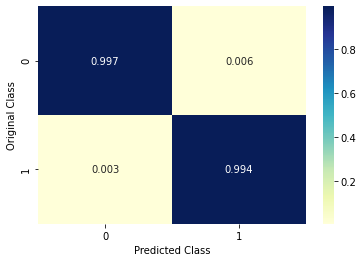

-------------------- Recall matrix (Row sum=1) --------------------


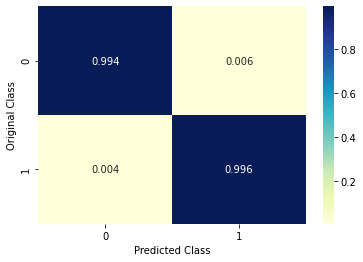

In [ ]:
x_cfl=XGBClassifier(n_estimators=100, learning_rate=0.1, colsample_bytree=0.1, max_depth=3,subsample=0.3)
x_cfl.fit(X_train_essay_bow,Y_train)
c_cfl=CalibratedClassifierCV(x_cfl,method='sigmoid')
c_cfl.fit(X_train_essay_bow,Y_train)

predict_y = c_cfl.predict_proba(X_train_essay_bow)
print ('train loss',log_loss(Y_train, predict_y))
predict_y = c_cfl.predict_proba(X_cv_essay_bow)
print ('cv loss',log_loss(Y_cv, predict_y))
predict_y = c_cfl.predict_proba(X_test_essay_bow)
print ('test loss',log_loss(Y_test, predict_y))
predict_and_plot_confusion_matrix(X_train_essay_bow, Y_train,X_cv_essay_bow, Y_cv, x_cfl)

#### Query point1

In [ ]:
clf=XGBClassifier(n_estimators=100, learning_rate=0.1, colsample_bytree=0.1, max_depth=3,subsample=0.3)
clf.fit(X_train_essay_bow,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow,Y_train)

test_point_index = 567

predicted_cls = sig_clf.predict(X_test_essay_bow[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", Y_test[test_point_index])

Predicted Class : 0
Actual Class : 0


#### Query point2

In [ ]:
clf =XGBClassifier(n_estimators=100, learning_rate=0.1, colsample_bytree=0.1, max_depth=3,subsample=0.3)
clf.fit(X_train_essay_bow,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow,Y_train)

test_point_index = 789

predicted_cls = sig_clf.predict(X_test_essay_bow[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", Y_test[test_point_index])

Predicted Class : 0
Actual Class : 0


### Applying Deep Learning Models

#### a.ANN(Artificial Neural Network)

In [5]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from keras import layers

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['original'])

word_to_index = tokenizer.word_index

x = tokenizer.texts_to_sequences(df['original'])

vocab_size = len(word_to_index)+1
vocab_size

x = pad_sequences(x, padding='post')

In [7]:
x.shape

(44898, 8389)

In [8]:
X_train,X_test,Y_train,Y_test=train_test_split(x,df['target'],test_size=0.33,stratify=df['target'])
print("X_train shape:",X_train.shape)
print("X_test shape:",X_test.shape)
print("Y_train shape:",Y_train.shape)
print("Y_test shape:",Y_test.shape)

X_train shape: (30081, 8389)
X_test shape: (14817, 8389)
Y_train shape: (30081,)
Y_test shape: (14817,)


In [ ]:
#output_dim=10=>to just increase the training time
model1 = Sequential()
model1.add(layers.Embedding(input_dim=vocab_size, output_dim=10,input_length=X_train.shape[1]))
model1.add(layers.GlobalAveragePooling1D())
model1.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 8389, 10)          1219770   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 1,219,781
Trainable params: 1,219,781
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model1.compile(loss=BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'])
history = model1.fit(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test))

Epoch 1/10
941/941 [==============================] - 40s 43ms/step - loss: 0.6837 - accuracy: 0.5551 - val_loss: 0.6657 - val_accuracy: 0.5378
Epoch 2/10
941/941 [==============================] - 43s 45ms/step - loss: 0.6274 - accuracy: 0.8074 - val_loss: 0.5806 - val_accuracy: 0.9205
Epoch 3/10
941/941 [==============================] - 40s 42ms/step - loss: 0.5306 - accuracy: 0.9076 - val_loss: 0.4825 - val_accuracy: 0.9324
Epoch 4/10
941/941 [==============================] - 44s 46ms/step - loss: 0.4380 - accuracy: 0.9277 - val_loss: 0.3985 - val_accuracy: 0.9461
Epoch 5/10
941/941 [==============================] - 47s 50ms/step - loss: 0.3649 - accuracy: 0.9418 - val_loss: 0.3357 - val_accuracy: 0.9516
Epoch 6/10
941/941 [==============================] - 44s 47ms/step - loss: 0.3097 - accuracy: 0.9490 - val_loss: 0.2867 - val_accuracy: 0.9515
Epoch 7/10
941/941 [==============================] - 42s 44ms/step - loss: 0.2674 - accuracy: 0.9566 - val_loss: 0.2499 - val_accuracy:

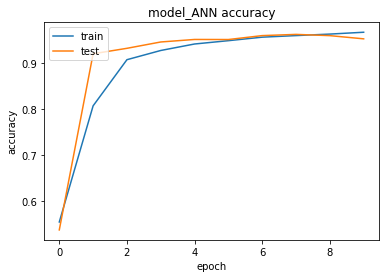

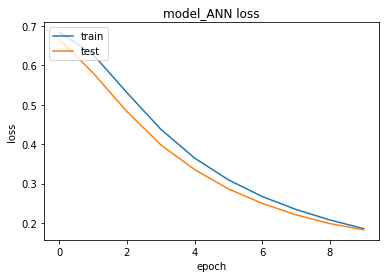

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_ANN accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_ANN loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_cap=model1.predict(X_test)

In [ ]:
Y_test

17185    0
42218    1
38726    1
14915    0
19461    0
        ..
20207    0
38506    1
15972    0
38710    1
28909    1
Name: target, Length: 14817, dtype: int64

In [ ]:
y_cap

array([[0.19473296],
       [0.8247422 ],
       [0.9935269 ],
       ...,
       [0.6536953 ],
       [0.9990686 ],
       [0.93055934]], dtype=float32)

In [ ]:
y_cap[y_cap<0.5]=0
y_cap[y_cap>0.5]=1

In [ ]:
print(classification_report(Y_test,y_cap))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95      7749
           1       0.92      0.98      0.95      7068

    accuracy                           0.95     14817
   macro avg       0.95      0.95      0.95     14817
weighted avg       0.95      0.95      0.95     14817



In [ ]:
cm = confusion_matrix(Y_test, y_cap)
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])

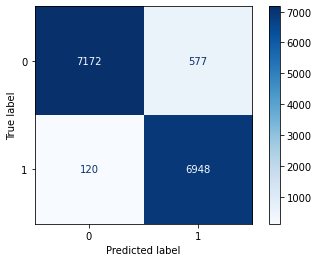

In [ ]:
disp = disp.plot(include_values=True, ax=None, xticks_rotation='horizontal', cmap=plt.cm.Blues)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test,y_cap)

0.9529594384828238

#### b.LSTM

In [ ]:
model2=Sequential()
model2.add(layers.Embedding(input_dim=vocab_size, output_dim=10,input_length=X_train.shape[1]))
model2.add(layers.Dropout(0.3))
model2.add(layers.LSTM(100))
model2.add(layers.Dropout(0.3))
model2.add(layers.Dense(1,activation='sigmoid'))
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 8389, 10)          1219770   
_________________________________________________________________
dropout (Dropout)            (None, 8389, 10)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               44400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 1,264,271
Trainable params: 1,264,271
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history2 = model2.fit(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test))

Epoch 1/10
941/941 [==============================] - 348s 335ms/step - loss: 0.6926 - accuracy: 0.5194 - val_loss: 0.6923 - val_accuracy: 0.5230
Epoch 2/10
941/941 [==============================] - 315s 335ms/step - loss: 0.6922 - accuracy: 0.5245 - val_loss: 0.6921 - val_accuracy: 0.5230
Epoch 3/10
941/941 [==============================] - 315s 335ms/step - loss: 0.6925 - accuracy: 0.5195 - val_loss: 0.6921 - val_accuracy: 0.5230
Epoch 4/10
941/941 [==============================] - 315s 335ms/step - loss: 0.6924 - accuracy: 0.5216 - val_loss: 0.6921 - val_accuracy: 0.5230
Epoch 5/10
941/941 [==============================] - 315s 334ms/step - loss: 0.6924 - accuracy: 0.5212 - val_loss: 0.6921 - val_accuracy: 0.5230
Epoch 6/10
941/941 [==============================] - 315s 335ms/step - loss: 0.6921 - accuracy: 0.5235 - val_loss: 0.6921 - val_accuracy: 0.5230
Epoch 7/10
941/941 [==============================] - 314s 334ms/step - loss: 0.6919 - accuracy: 0.5256 - val_loss: 0.6922 -

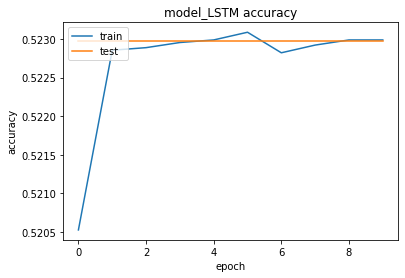

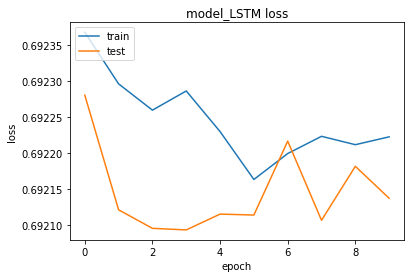

In [ ]:
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model_LSTM accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model_LSTM loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_cap=model2.predict(X_test)

In [ ]:
y_cap

array([[0.48182622],
       [0.48182622],
       [0.48182622],
       ...,
       [0.48182622],
       [0.48182622],
       [0.48182622]], dtype=float32)

In [ ]:
y_cap[y_cap<0.5]=0
y_cap[y_cap>0.5]=1

In [ ]:
print(classification_report(Y_test,y_cap))

              precision    recall  f1-score   support

           0       0.52      1.00      0.69      7749
           1       0.00      0.00      0.00      7068

    accuracy                           0.52     14817
   macro avg       0.26      0.50      0.34     14817
weighted avg       0.27      0.52      0.36     14817



In [ ]:
cm = confusion_matrix(Y_test, y_cap)
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])

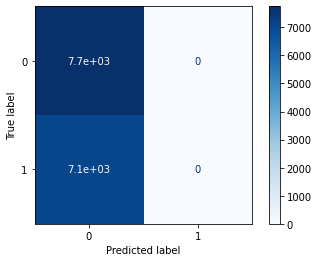

In [ ]:
disp = disp.plot(include_values=True, ax=None, xticks_rotation='horizontal', cmap=plt.cm.Blues)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test,y_cap)

0.5229803603968415

####Applying Bi-directional LSTM

In [9]:
model3=Sequential()
model3.add(layers.Embedding(input_dim=vocab_size, output_dim=10,input_length=X_train.shape[1]))
model3.add(layers.Bidirectional(layers.LSTM(100)))
model3.add(layers.Dropout(0.3))
model3.add(layers.Dense(1,activation='sigmoid'))
model3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [10]:
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 8389, 10)          1219770   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               88800     
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 1,308,771
Trainable params: 1,308,771
Non-trainable params: 0
_________________________________________________________________


In [11]:
history3 = model3.fit(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test))

Epoch 1/10
941/941 [==============================] - 639s 643ms/step - loss: 0.2709 - accuracy: 0.8829 - val_loss: 0.0069 - val_accuracy: 0.9985
Epoch 2/10
941/941 [==============================] - 603s 641ms/step - loss: 0.0040 - accuracy: 0.9992 - val_loss: 0.0026 - val_accuracy: 0.9995
Epoch 3/10
941/941 [==============================] - 601s 639ms/step - loss: 0.0025 - accuracy: 0.9995 - val_loss: 0.0022 - val_accuracy: 0.9996
Epoch 4/10
941/941 [==============================] - 601s 638ms/step - loss: 4.3534e-04 - accuracy: 0.9999 - val_loss: 0.0032 - val_accuracy: 0.9992
Epoch 5/10
941/941 [==============================] - 601s 639ms/step - loss: 8.7502e-04 - accuracy: 0.9998 - val_loss: 0.0035 - val_accuracy: 0.9989
Epoch 6/10
941/941 [==============================] - 600s 638ms/step - loss: 1.8055e-04 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 0.9992
Epoch 7/10
941/941 [==============================] - 599s 637ms/step - loss: 1.7903e-05 - accuracy: 1.0000 - va

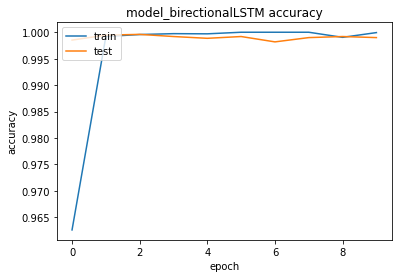

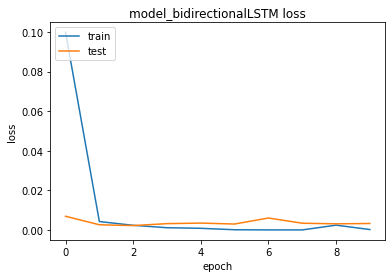

In [12]:
# summarize history for accuracy
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model_birectionalLSTM accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model_bidirectionalLSTM loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
y_cap=model3.predict(X_test)

In [14]:
y_cap

array([[1.0000000e+00],
       [2.0582711e-05],
       [3.9911578e-05],
       ...,
       [8.4275880e-06],
       [9.9991596e-01],
       [4.8286805e-05]], dtype=float32)

In [15]:
y_cap[y_cap<0.5]=0
y_cap[y_cap>0.5]=1

In [16]:
print(classification_report(Y_test,y_cap))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7749
           1       1.00      1.00      1.00      7068

    accuracy                           1.00     14817
   macro avg       1.00      1.00      1.00     14817
weighted avg       1.00      1.00      1.00     14817



In [17]:
cm = confusion_matrix(Y_test, y_cap)
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])

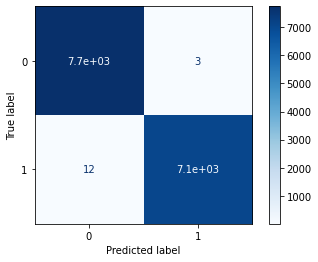

In [18]:
disp = disp.plot(include_values=True, ax=None, xticks_rotation='horizontal', cmap=plt.cm.Blues)
plt.show()

In [19]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test,y_cap)

0.998987649321725

In [20]:
from sklearn.metrics import confusion_matrix

In [21]:
confusion_matrix(Y_test,y_cap)

array([[7746,    3],
       [  12, 7056]])